## Exercise: Exploring Marathon Finishing Times
Here we’ll look at using Seaborn to help visualize and understand finishing results from a marathon. We will start by downloading the data from the Web, and loading it into Pandas:

In [1]:
# !curl -O https://raw.githubusercontent.com/jakevdp/marathon-data/master/marathon-data.csv
# or it can be downloaded through the Schoology.

# Let's import pandas, numpy, seaborn

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# For time stamps
from datetime import datetime

# For division
from __future__ import division

Let's load "marathon-data.csv"

In [45]:
data = pd.read_csv("marathon-data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37250 entries, 0 to 37249
Data columns (total 4 columns):
age       37250 non-null int64
gender    37250 non-null object
split     37250 non-null object
final     37250 non-null object
dtypes: int64(1), object(3)
memory usage: 1.1+ MB


Let's see what contents are there.

In [46]:
data.head()

,age,gender,split,final
0,33,M,01:05:38,02:08:51
1,32,M,01:06:26,02:09:28
2,31,M,01:06:49,02:10:42
3,38,M,01:06:16,02:13:45
4,31,M,01:06:32,02:13:59


In [47]:
data.dtypes

age        int64
gender    object
split     object
final     object
dtype: object

In [49]:
def convert_time(s):
    h, m, s = map(int, s.split(':'))
    return pd.Timedelta(hours=h, minutes=m, seconds=s)

In [50]:
data = pd.read_csv('marathon-data.csv', converters={'split':convert_time, 'final':convert_time})

In [51]:
data.dtypes

age                 int64
gender             object
split     timedelta64[ns]
final     timedelta64[ns]
dtype: object

In [52]:
data['split_sec'] = data['split'].astype(int) / 1E9

In [53]:
data['final_sec'] = data['final'].astype(int) / 1E9

In [54]:
data.head()

,age,gender,split,final,split_sec,final_sec
0,33,M,01:05:38,02:08:51,3938.0,7731.0
1,32,M,01:06:26,02:09:28,3986.0,7768.0
2,31,M,01:06:49,02:10:42,4009.0,7842.0
3,38,M,01:06:16,02:13:45,3976.0,8025.0
4,31,M,01:06:32,02:13:59,3992.0,8039.0


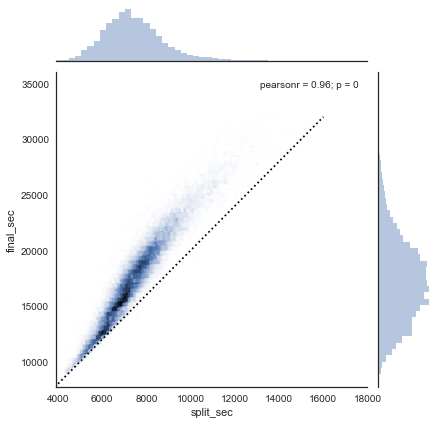

In [56]:
with sns.axes_style('white'):
            g = sns.jointplot("split_sec", "final_sec", data, kind='hex')
            g.ax_joint.plot(np.linspace(4000, 16000),
                            np.linspace(8000, 32000), ':k')

The dotted line shows where someone’s time would lie if they ran the marathon at a perfectly steady pace. The fact that the distribution lies above this indicates (as you might expect) that most people slow down over the course of the marathon. If you have run competitively, you’ll know that those who do the opposite—run faster during the second half of the race—are said to have “negative-split” the race.

In [57]:
data['split_frac'] = 1 - 2 * data['split_sec'] / data['final_sec']
data.head()

,age,gender,split,final,split_sec,final_sec,split_frac
0,33,M,01:05:38,02:08:51,3938.0,7731.0,-0.018756
1,32,M,01:06:26,02:09:28,3986.0,7768.0,-0.026262
2,31,M,01:06:49,02:10:42,4009.0,7842.0,-0.022443
3,38,M,01:06:16,02:13:45,3976.0,8025.0,0.009097
4,31,M,01:06:32,02:13:59,3992.0,8039.0,0.006842


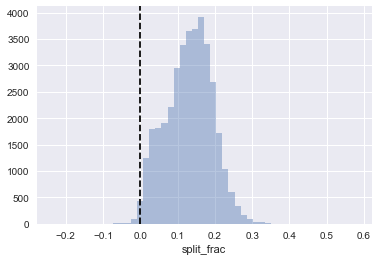

In [61]:
sns.distplot(data['split_frac'], kde=False);
plt.axvline(0, color="k", linestyle="--");

In [62]:
sum(data.split_frac < 0)

251

Out of nearly 40,000 participants, there were only 250 people who negative-split their marathon.

Let’s see whether there is any correlation between this split fraction and other variables. We’ll do this using a pairgrid, which draws plots of all these correlations

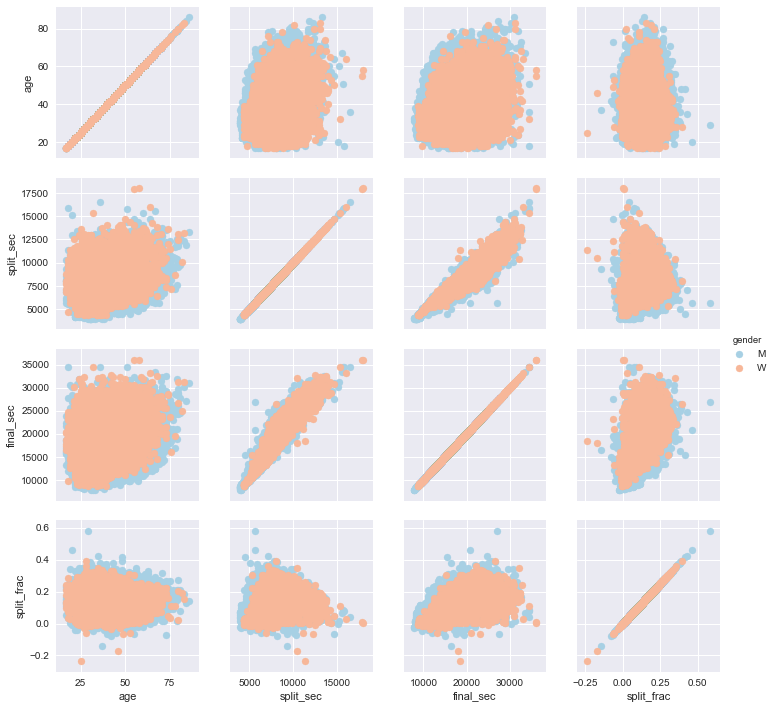

In [65]:
g = sns.PairGrid(data, vars=['age', 'split_sec', 'final_sec', 'split_frac'],
                 hue='gender', palette='RdBu_r')
g.map(plt.scatter, alpha=1)
g.add_legend();

It looks like the split fraction does not correlate particularly with age, but does correlate with the final time: faster runners tend to have closer to even splits on their marathon time.

The difference between men and women here is interesting. Let’s look at the histogram of split fractions for these two groups

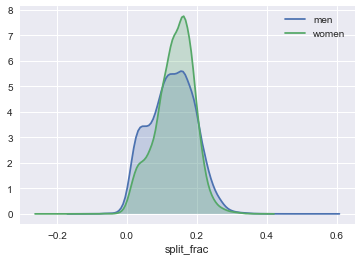

In [67]:
sns.kdeplot(data.split_frac[data.gender=='M'], label='men', shade=True)
sns.kdeplot(data.split_frac[data.gender=='W'], label='women', shade=True)
plt.xlabel('split_frac');

The interesting thing here is that there are many more men than women who are running close to an even split! This almost looks like some kind of bimodal distribution among the men and women. Let’s see if we can suss out what’s going on by looking at the distributions as a function of age.

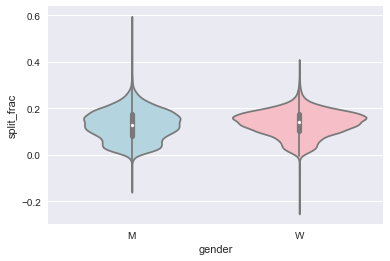

In [68]:
sns.violinplot("gender", "split_frac", data=data,
               palette=["lightblue", "lightpink"]);

This is yet another way to compare the distributions between men and women.

Let’s look a little deeper, and compare these violin plots as a function of age. We’ll start by creating a new column in the array that specifies the decade of age that each person is in the Figure.

In [69]:
data['age_dec'] = data.age.map(lambda age: 10 * (age // 10))

In [70]:
data.head()

,age,gender,split,final,split_sec,final_sec,split_frac,age_dec
0,33,M,01:05:38,02:08:51,3938.0,7731.0,-0.018756,30
1,32,M,01:06:26,02:09:28,3986.0,7768.0,-0.026262,30
2,31,M,01:06:49,02:10:42,4009.0,7842.0,-0.022443,30
3,38,M,01:06:16,02:13:45,3976.0,8025.0,0.009097,30
4,31,M,01:06:32,02:13:59,3992.0,8039.0,0.006842,30


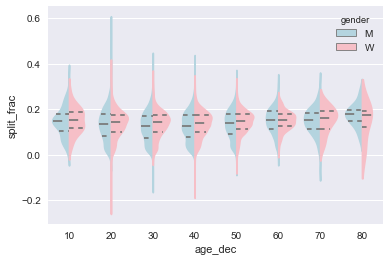

In [71]:
men = (data.gender == 'M')
women = (data.gender == 'W')

with sns.axes_style(style=None):
    sns.violinplot("age_dec", "split_frac", hue="gender", data=data,
                  split=True, inner="quartile",
                  palette=["lightblue", "lightpink"]);

Looking at this, we can see where the distributions of men and women differ: the split distributions of men in their 20s to 50s show a pronounced over-density toward lower splits when compared to women of the same age (or of any age, for that matter).

Also surprisingly, the 80-year-old women seem to outperform everyone in terms of their split time. This is probably due to the fact that we’re estimating the distribution from small numbers, as there are only a handful of runners in that range:

In [72]:
(data.age > 80).sum()

7

Back to the men with negative splits: who are these runners? Does this split fraction correlate with finishing quickly? We can plot this very easily. We’ll use regplot, which will automatically fit a linear regression to the data.

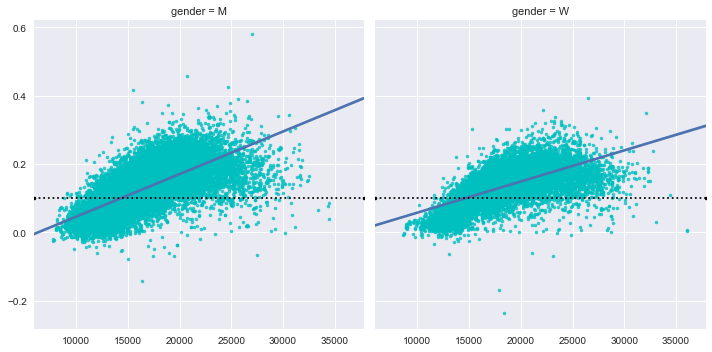

In [74]:
g = sns.lmplot('final_sec', 'split_frac', col='gender', data=data,
                       markers=".", scatter_kws=dict(color='c'))
g.map(plt.axhline, y=0.1, color="k", ls=":");

Apparently the people with fast splits are the elite runners who are finishing within ~15,000 seconds, or about 4 hours. People slower than that are much less likely to have a fast second split.